In [1]:
%load_ext autoreload
%autoreload 2

import ase.io
import numpy as np

import rascaline
import metatensor
from metatensor import Labels, TensorBlock, TensorMap
import chemiscope

from rascaline.utils import clebsch_gordan, PowerSpectrum
# import clebsch_gordan
# import rotations

In [2]:
from rascaline.utils import clebsch_gordan, PowerSpectrum

rascal_hypers = {
    "cutoff": 3.0,  # Angstrom
    "max_radial": 2,  # Exclusive
    "max_angular": 3,  # Inclusive
    "atomic_gaussian_width": 0.2,
    "radial_basis": {"Gto": {}},
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
    "center_atom_weight": 1.0,
}

frames = ase.io.read("frame.xyz", ":")
sphex = rascaline.SphericalExpansion(**rascal_hypers)
ps = PowerSpectrum(sphex).compute(frames)

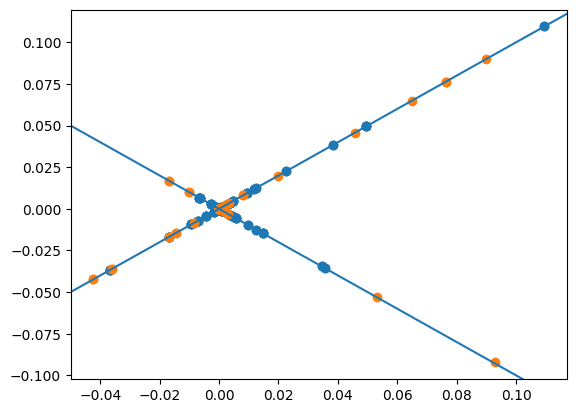

In [3]:
import ase.io
import matplotlib.pyplot as plt
from rascaline.utils import clebsch_gordan, PowerSpectrum

rascal_hypers = {
    "cutoff": 3.0,  # Angstrom
    "max_radial": 2,  # Exclusive
    "max_angular": 3,  # Inclusive
    "atomic_gaussian_width": 0.2,
    "radial_basis": {"Gto": {}},
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
    "center_atom_weight": 1.0,
}

frames = ase.io.read("frame.xyz", ":")  # single water monomer

# PowerSpectrum (python implementation)
sphex = rascaline.SphericalExpansion(**rascal_hypers)
ps = PowerSpectrum(sphex).compute(frames)

# LSOAP
nu_1_tensor = sphex.compute(frames)
lsoap = clebsch_gordan.lambda_soap_vector(
    nu_1_tensor=nu_1_tensor,
    angular_selection=[0],
)
# Some metadata manipulation to get it to match PowerSpectrum
# ...
keys = lsoap.keys.remove(name="spherical_harmonics_l")
lsoap = TensorMap(keys=keys, blocks=[b.copy() for b in lsoap.blocks()])

# Remove components axis
blocks = []
for block in lsoap.blocks():
    n_samples, n_props = block.values.shape[0], block.values.shape[2]
    new_props = block.properties
    new_props = new_props.remove(name="l1")
    new_props = new_props.rename(old="l2", new="l")
    blocks.append(
        TensorBlock(
            values=block.values.reshape((n_samples, n_props)),
            samples=block.samples,
            components=[],
            properties=new_props,
        )
    )
lsoap = TensorMap(keys=lsoap.keys, blocks=blocks)

# Parity plot
fig, ax = plt.subplots()
for key in lsoap.keys:
    ax.scatter(ps[key].values, lsoap[key].values)
ax.axline((0, 0), slope=1)
ax.axline((0, 0), slope=-1)

In [ ]:
nu_1_tensor = sphex.compute(frames)
lsoap = clebsch_gordan.lambda_soap_vector(
    nu_1_tensor=nu_1_tensor,
    angular_selection=[0],
)
keys = lsoap.keys.remove(name="spherical_harmonics_l")
lsoap = TensorMap(keys=keys, blocks=[b.copy() for b in lsoap.blocks()])

# Remove components axis
blocks = []
for block in lsoap.blocks():
    n_samples, n_props = block.values.shape[0], block.values.shape[2]
    new_props = block.properties
    new_props = new_props.remove(name="l1")
    new_props = new_props.rename(old="l2", new="l")
    blocks.append(
        TensorBlock(
            values=block.values.reshape((n_samples, n_props)),
            samples=block.samples,
            components=[],
            properties=new_props,
        )
    )

lsoap = TensorMap(keys=lsoap.keys, blocks=blocks)
lsoap

In [ ]:
# metatensor.equal_metadata(metatensor.sort(lsoap), metatensor.sort(ps))
assert metatensor.equal_metadata(lsoap, ps)
assert metatensor.allclose(metatensor.abs(lsoap), metatensor.abs(ps))

In [ ]:
diff = lsoap.block(0).values - ps.block(0).values
diff

In [ ]:
mask = abs(diff[0]) > 1e-10
mask

In [ ]:
lsoap.block(0).properties.names

In [ ]:
lsoap.block(0).properties.values[mask]

In [ ]:
mask[0]

In [ ]:
lsoap.block(0).properties

In [ ]:
ps.block(0).values

In [ ]:
metatensor.subtract(lsoap, ps).block(0).values

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for key in lsoap.keys:
    ax.scatter(ps[key].values, lsoap[key].values)
    ax.axline((0, 0), slope=1)
    ax.axline((0, 0), slope=-1)

## Generate a rascaline SphericalExpansion calculator

In [ ]:
frames = ase.io.read("frame copy.xyz", ":")
# frames = ase.io.read("combined_magres_spherical.xyz", ":1")

# Define hyperparameters for generating the rascaline SphericalExpansion
rascal_hypers = {
    "cutoff": 3.0,  # Angstrom
    "max_radial": 4,  # Exclusive
    "max_angular": 5,  # Inclusive
    "atomic_gaussian_width": 0.2,
    "radial_basis": {"Gto": {}},
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
    "center_atom_weight": 1.0,
}
calculator = rascaline.SphericalExpansion(**rascal_hypers)
nu_1 = calculator.compute(frames)

## Generate output TensorMaps with:
### a) only metadata and b) actually doing the CG combinations

In [ ]:
%%timeit
nu_3 = clebsch_gordan.combine_single_center_to_body_order_metadata_only(
    nu_1_tensor=nu_1,
    target_body_order=3,
    # angular_cutoff=6,
    # angular_selection=[0, 1, 2],
    # parity_selection=[+1],
)
# [np.unique(i[0].column("spherical_harmonics_l")) for i in nu_3]

In [ ]:
%%timeit
nu_3 = clebsch_gordan.combine_single_center_to_body_order(
    nu_1_tensor=nu_1,
    target_body_order=3,
    # angular_cutoff=6,
    # angular_selection=[0, 1, 2],
    # parity_selection=[+1],
)
# [np.unique(i[0].column("spherical_harmonics_l")) for i in nu_3]

# Equivariance Test - SO(3) for $\nu=3$

In [ ]:
# Define target angular channels
angular_selection = [0, 2]

# Generate Wigner-D matrices, initialized with random angles
wig = rotations.WignerDReal(lmax=rascal_hypers["max_angular"])
print("Random rotation angles (rad):", wig.angles)

# Randomly rigidly rotate the frame
frames_so3 = [rotations.transform_frame_so3(frame, wig.angles) for frame in frames]
assert not np.allclose(frames[-1].positions, frames_so3[-1].positions)

# Generate nu=3 descriptor for both frames
print("Computing nu = 3 descriptor for unrotated frames...")
nu_1 = calculator.compute(frames)
nu_3 = clebsch_gordan.combine_single_center_to_body_order(
    nu_1_tensor=nu_1,
    target_body_order=3,
    angular_selection=angular_selection,
    parity_selection=[+1],
)
print("Computing nu = 3 descriptor for rotated frames...")
nu_1_rot = calculator.compute(frames_so3)
nu_3_rot = clebsch_gordan.combine_single_center_to_body_order(
    nu_1_tensor=nu_1_rot,
    target_body_order=3,
    angular_selection=angular_selection,
    parity_selection=[+1],
)

# Rotate the lambda-SOAP descriptor of the unrotated frame
nu_3_transf = wig.transform_tensormap_so3(nu_3)

# Check for equivariance!
assert metatensor.equal_metadata(nu_3_transf, nu_3_rot)
assert metatensor.allclose(nu_3_transf, nu_3_rot)
print("SO(3) EQUIVARIANT!")

# chemiscope.show(frames + frames_so3, mode="structure")

# Equivariance Test - O(3) on $\nu=2$ (i.e. $\lambda$-SOAP)

In [ ]:
# Define target lambda channels
angular_selection = [0, 1, 2, 3, 4, 5]

# Generate Wigner-D matrices, initialized with random angles
wig = rotations.WignerDReal(lmax=rascal_hypers["max_angular"])
print("Random rotation angles (rad):", wig.angles)

# Apply an O(3) transformation to the frame
frames_o3 = [rotations.transform_frame_o3(frame, wig.angles) for frame in frames]
assert not np.allclose(frames[-1].positions, frames_o3[-1].positions)

# Generate lambda-SOAP for both frames
print("Computing lambda-SOAP descriptor for unrotated frames...")
nu_1 = calculator.compute(frames)
lsoap = clebsch_gordan.lambda_soap_vector(
    nu_1_tensor=nu_1,
    angular_selection=angular_selection,
)
print("Computing lambda-SOAP descriptor for rotated frames...")
nu_1_rot = calculator.compute(frames_o3)
lsoap_o3 = clebsch_gordan.lambda_soap_vector(
    nu_1_tensor=nu_1_rot,
    angular_selection=angular_selection,
)

# Apply the O(3) transformation to the TensorMap
lsoap_transf = wig.transform_tensormap_o3(lsoap)

# Check for equivariance!
assert metatensor.equal_metadata(lsoap_transf, lsoap_o3)
assert metatensor.allclose(lsoap_transf, lsoap_o3)
print("O(3) EQUIVARIANT!")

# chemiscope.show(frames + frames_o3, mode="structure")

# Old v new lambda-SOAP

In [ ]:
%%timeit
lsoap_old = old_clebsch_gordan.lambda_soap_vector(frames, rascal_hypers, lambda_cut=5)

size = 0
for block in lsoap_old:
    size += np.prod(block.values.shape)
print("Size:", size)

In [ ]:
%%timeit
calculator = rascaline.SphericalExpansion(**rascal_hypers)
nu_1 = calculator.compute(frames)
lsoap_new = clebsch_gordan.lambda_soap_vector(nu_1, angular_cutoff=5)

size = 0
for block in lsoap_new:
    size += np.prod(block.values.shape)
print("Size:", size)

# Dense v Sparse

In [ ]:
# Dense
calculator = rascaline.SphericalExpansion(**rascal_hypers)
nu_1 = calculator.compute(frames[:2])
nu_2_dense = clebsch_gordan.combine_single_center_to_body_order(
    nu_1,
    target_body_order=3,
    angular_cutoff=5,
    use_sparse=False,
)
nu_2_dense

In [ ]:
# Sparse
calculator = rascaline.SphericalExpansion(**rascal_hypers)
nu_1 = calculator.compute(frames[:2])
nu_2_sparse = clebsch_gordan.combine_single_center_to_body_order(
    nu_1,
    target_body_order=3,
    angular_cutoff=5,
    use_sparse=True,
)
nu_2_sparse

In [ ]:
# Check sparse == dense
metatensor.allclose(nu_2_dense, nu_2_sparse)

# Test system 1

In [ ]:
# %%timeit

# use_sparse = False

# tensor_dense = clebsch_gordan.n_body_iteration_single_center(
#     frames,
#     rascal_hypers=rascal_hypers,
#     nu_target=3,
#     lambdas=lambdas,
#     use_sparse=use_sparse,
# )
# tensor_dense

# # timeit comes out at about 22 seconds for nu_target = 3

In [ ]:
# %%timeit

# use_sparse = True

# tensor_sparse = clebsch_gordan.n_body_iteration_single_center(
#     frames,
#     rascal_hypers=rascal_hypers,
#     nu_target=3,
#     lambdas=lambdas,
#     use_sparse=use_sparse,
# )
# tensor_sparse

# # timeit comes out at about 13 seconds for nu_target = 3

In [ ]:
# tensor_sparse = clebsch_gordan.n_body_iteration_single_center(
#     frames,
#     rascal_hypers=rascal_hypers,
#     nu_target=3,
#     lambdas=lambdas,
#     use_sparse=True,
# )

# tensor_dense = clebsch_gordan.n_body_iteration_single_center(
#     frames,
#     rascal_hypers=rascal_hypers,
#     nu_target=3,
#     lambdas=lambdas,
#     use_sparse=False,
# )

# assert metatensor.allclose(tensor_dense, tensor_sparse)

# Test system 2

In [ ]:
# frames = [ase.io.read("frame.xyz")]

# lambdas = np.array([0, 2])

# rascal_hypers = {
#     "cutoff": 3.0,  # Angstrom
#     "max_radial": 6,  # Exclusive
#     "max_angular": 5,  # Inclusive
#     "atomic_gaussian_width": 0.2,
#     "radial_basis": {"Gto": {}},
#     "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
#     "center_atom_weight": 1.0,
# }

# n_body = clebsch_gordan.n_body_iteration_single_center(
#     frames,
#     rascal_hypers=rascal_hypers,
#     nu_target=3,
#     lambdas=lambdas,
# )
# n_body

In [ ]:
# def sort_tm(tm):
#     blocks = []
#     for _, block in tm.items():
#         values = block.values

#         samples_values = block.samples.values
#         sorted_idx = native_list_argsort([tuple(row.tolist()) for row in block.samples.values])
#         samples_values = samples_values[sorted_idx]
#         values = values[sorted_idx]

#         components_values = []
#         for i, component in enumerate(block.components):
#             component_values = component.values
#             sorted_idx = native_list_argsort([tuple(row.tolist()) for row in component.values])
#             components_values.append( component_values[sorted_idx] )
#             values = np.take(values, sorted_idx, axis=i+1)

#         properties_values = block.properties.values
#         sorted_idx = native_list_argsort([tuple(row.tolist()) for row in block.properties.values])
#         properties_values = properties_values[sorted_idx]
#         values = values[..., sorted_idx]

#         blocks.append(
#             TensorBlock(
#                 values=values,
#                 samples=Labels(values=samples_values, names=block.samples.names),
#                 components=[Labels(values=components_values[i], names=component.names) for i, component in enumerate(block.components)],
#                 properties=Labels(values=properties_values, names=block.properties.names)
#             )
#         )
#     return TensorMap(keys=tm.keys, blocks=blocks)


# def native_list_argsort(native_list):
#     return sorted(range(len(native_list)), key=native_list.__getitem__)


In [ ]:

# # Manipulate metadata from old LSOAP
# lsoap_old = metatensor.permute_dimensions(lsoap_old0, axis="properties", dimensions_indexes=[2, 5, 0, 1, 3, 4])
# lsoap_old = metatensor.rename_dimension(lsoap_old, axis="properties", old="l_1", new="l1")
# lsoap_old = metatensor.rename_dimension(lsoap_old, axis="properties", old="l_2", new="l2")
# lsoap_old = metatensor.rename_dimension(lsoap_old, axis="properties", old="n_1", new="n1")
# lsoap_old = metatensor.rename_dimension(lsoap_old, axis="properties", old="n_2", new="n2")

# # Slice TM to symmetrize l-values
# sliced_blocks = []
# for key, block in lsoap_old.items():
#     # Filter properties l1 <= l2
#     mask = [entry[0] <= entry[1] for entry in block.properties]
#     new_labels = Labels(names=block.properties.names, values=block.properties.values[mask])

#     # Slice block
#     sliced_block = metatensor.slice_block(block, axis="properties", labels=new_labels)
#     sliced_blocks.append(sliced_block)

# # Check equal metadata
# lsoap_old = sort_tm(TensorMap(keys=lsoap_old.keys, blocks=sliced_blocks))
# lsoap_new = sort_tm(lsoap_new0)
# assert metatensor.equal_metadata(lsoap_old, lsoap_new)

# # Check equal values
# metatensor.allclose_raise(lsoap_old, lsoap_new)

In [ ]:
# for key in lsoap_old.keys:
#     b1 = lsoap_old[key]
#     b2 = lsoap_new[key]

#     print(key, metatensor.allclose_block(b1, b2))

In [ ]:
# np.linalg.norm(
#     lsoap_old.block(inversion_sigma=1, spherical_harmonics_l=1, species_center=3).values
#     - lsoap_new.block(
#         inversion_sigma=1, spherical_harmonics_l=1, species_center=3
#     ).values
# )

In [ ]:
# # NOW SLICE TO l1 == l2

# # Slice TM
# sliced_blocks = []
# for key, block in lsoap_old.items():
#     # Filter properties
#     mask = [entry[0] == entry[1] for entry in block.properties]
#     new_labels = Labels(names=block.properties.names, values=block.properties.values[mask])

#     # Slice block
#     sliced_blocks.append(metatensor.slice_block(block, axis="properties", labels=new_labels))

# lsoap_old_sliced = TensorMap(keys=lsoap_old.keys, blocks=sliced_blocks)

# # Slice TM
# sliced_blocks = []
# for key, block in lsoap_new.items():
#     # Filter properties
#     mask = [entry[0] == entry[1] for entry in block.properties]
#     new_labels = Labels(names=block.properties.names, values=block.properties.values[mask])

#     # Slice block
#     sliced_blocks.append(metatensor.slice_block(block, axis="properties", labels=new_labels))

# lsoap_new_sliced = TensorMap(keys=lsoap_new.keys, blocks=sliced_blocks)

# assert metatensor.equal_metadata(lsoap_old_sliced, lsoap_new_sliced)
# assert metatensor.allclose_raise(lsoap_old_sliced, lsoap_new_sliced)